## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2, 0.5, 0.8]
redice_lr_patient = [5, 10, 20]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________________________________________________________

49/49 [==============================] - 6s 118ms/step - loss: 1.5880 - accuracy: 0.4467 - val_loss: 1.6730 - val_accuracy: 0.4190
Epoch 12/25
49/49 [==============================] - 6s 119ms/step - loss: 1.5689 - accuracy: 0.4532 - val_loss: 1.6648 - val_accuracy: 0.4193
Epoch 13/25
49/49 [==============================] - 6s 119ms/step - loss: 1.5506 - accuracy: 0.4596 - val_loss: 1.6542 - val_accuracy: 0.4219
Epoch 14/25
49/49 [==============================] - 6s 118ms/step - loss: 1.5339 - accuracy: 0.4659 - val_loss: 1.6482 - val_accuracy: 0.4200
Epoch 15/25
49/49 [==============================] - 6s 118ms/step - loss: 1.5190 - accuracy: 0.4721 - val_loss: 1.6435 - val_accuracy: 0.4290
Epoch 16/25
49/49 [==============================] - 6s 118ms/step - loss: 1.5033 - accuracy: 0.4780 - val_loss: 1.6317 - val_accuracy: 0.4304
Epoch 17/25
49/49 [==============================] - 6s 118ms/step - loss: 1.4890 - accuracy: 0.4819 - val_loss: 1.6240 - val_accuracy: 0.4342
Epoch 18/25

Epoch 1/25
49/49 [==============================] - 22s 452ms/step - loss: 2.4956 - accuracy: 0.2006 - val_loss: 2.2244 - val_accuracy: 0.1643
Epoch 2/25
49/49 [==============================] - 6s 115ms/step - loss: 2.0581 - accuracy: 0.3051 - val_loss: 2.0802 - val_accuracy: 0.2466
Epoch 3/25
49/49 [==============================] - 5s 112ms/step - loss: 1.9067 - accuracy: 0.3443 - val_loss: 1.9828 - val_accuracy: 0.2903
Epoch 4/25
49/49 [==============================] - 6s 117ms/step - loss: 1.8237 - accuracy: 0.3709 - val_loss: 1.9014 - val_accuracy: 0.3234
Epoch 5/25
49/49 [==============================] - 6s 118ms/step - loss: 1.7663 - accuracy: 0.3878 - val_loss: 1.8394 - val_accuracy: 0.3469
Epoch 6/25
49/49 [==============================] - 6s 118ms/step - loss: 1.7233 - accuracy: 0.4010 - val_loss: 1.7812 - val_accuracy: 0.3731
Epoch 7/25
49/49 [==============================] - 6s 118ms/step - loss: 1.6864 - accuracy: 0.4127 - val_loss: 1.7389 - val_accuracy: 0.3877
Epoch

49/49 [==============================] - 6s 118ms/step - loss: 1.3960 - accuracy: 0.5137 - val_loss: 1.5737 - val_accuracy: 0.4459
Epoch 24/25
49/49 [==============================] - 6s 119ms/step - loss: 1.3848 - accuracy: 0.5183 - val_loss: 1.5685 - val_accuracy: 0.4459
Epoch 25/25
49/49 [==============================] - 6s 117ms/step - loss: 1.3748 - accuracy: 0.5207 - val_loss: 1.5638 - val_accuracy: 0.4483
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 20
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_15 (Batc (None, 512)               2048      
_______________________________________

Epoch 10/25
49/49 [==============================] - 6s 118ms/step - loss: 1.6060 - accuracy: 0.4418 - val_loss: 1.6800 - val_accuracy: 0.4140
Epoch 11/25
49/49 [==============================] - 6s 119ms/step - loss: 1.5840 - accuracy: 0.4501 - val_loss: 1.6677 - val_accuracy: 0.4171
Epoch 12/25
49/49 [==============================] - 6s 121ms/step - loss: 1.5630 - accuracy: 0.4573 - val_loss: 1.6565 - val_accuracy: 0.4218
Epoch 13/25
49/49 [==============================] - 6s 120ms/step - loss: 1.5457 - accuracy: 0.4636 - val_loss: 1.6493 - val_accuracy: 0.4215
Epoch 14/25
49/49 [==============================] - 6s 120ms/step - loss: 1.5284 - accuracy: 0.4681 - val_loss: 1.6390 - val_accuracy: 0.4240
Epoch 15/25
49/49 [==============================] - 6s 119ms/step - loss: 1.5130 - accuracy: 0.4733 - val_loss: 1.6303 - val_accuracy: 0.4297
Epoch 16/25
49/49 [==============================] - 6s 119ms/step - loss: 1.4974 - accuracy: 0.4794 - val_loss: 1.6212 - val_accuracy: 0.4311

Epoch 1/25
49/49 [==============================] - 29s 590ms/step - loss: 2.5014 - accuracy: 0.2012 - val_loss: 2.2046 - val_accuracy: 0.1935
Epoch 2/25
49/49 [==============================] - 5s 111ms/step - loss: 2.0606 - accuracy: 0.3044 - val_loss: 2.0991 - val_accuracy: 0.2511
Epoch 3/25
49/49 [==============================] - 6s 113ms/step - loss: 1.9056 - accuracy: 0.3473 - val_loss: 1.9938 - val_accuracy: 0.2888
Epoch 4/25
49/49 [==============================] - 6s 121ms/step - loss: 1.8204 - accuracy: 0.3713 - val_loss: 1.8972 - val_accuracy: 0.3263
Epoch 5/25
49/49 [==============================] - 6s 119ms/step - loss: 1.7591 - accuracy: 0.3890 - val_loss: 1.8303 - val_accuracy: 0.3521
Epoch 6/25
49/49 [==============================] - 6s 120ms/step - loss: 1.7117 - accuracy: 0.4050 - val_loss: 1.7688 - val_accuracy: 0.3751
Epoch 7/25
49/49 [==============================] - 6s 118ms/step - loss: 1.6746 - accuracy: 0.4175 - val_loss: 1.7304 - val_accuracy: 0.3885
Epoch

Epoch 22/25
49/49 [==============================] - 6s 119ms/step - loss: 0.4601 - accuracy: 0.8613 - val_loss: 1.5112 - val_accuracy: 0.5306
Epoch 23/25
49/49 [==============================] - 6s 120ms/step - loss: 0.4422 - accuracy: 0.8686 - val_loss: 1.5338 - val_accuracy: 0.5184
Epoch 24/25
49/49 [==============================] - 6s 120ms/step - loss: 0.4232 - accuracy: 0.8768 - val_loss: 1.5522 - val_accuracy: 0.5221
Epoch 25/25
49/49 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8825
Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
49/49 [==============================] - 6s 121ms/step - loss: 0.4085 - accuracy: 0.8825 - val_loss: 1.5462 - val_accuracy: 0.5264
Numbers of exp: 10, reduce_factor: 0.20, reduce_patient: 10
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 3072)]      

49/49 [==============================] - 6s 122ms/step - loss: 1.2620 - accuracy: 0.5628 - val_loss: 1.4992 - val_accuracy: 0.4768
Epoch 8/25
49/49 [==============================] - 6s 120ms/step - loss: 1.2294 - accuracy: 0.5768 - val_loss: 1.4763 - val_accuracy: 0.4840
Epoch 9/25
49/49 [==============================] - 6s 120ms/step - loss: 1.1976 - accuracy: 0.5889 - val_loss: 1.5121 - val_accuracy: 0.4714
Epoch 10/25
49/49 [==============================] - 6s 120ms/step - loss: 1.1699 - accuracy: 0.5973 - val_loss: 1.4637 - val_accuracy: 0.4882
Epoch 11/25
49/49 [==============================] - 6s 123ms/step - loss: 1.1433 - accuracy: 0.6077 - val_loss: 1.4418 - val_accuracy: 0.4929
Epoch 12/25
49/49 [==============================] - 6s 121ms/step - loss: 1.1175 - accuracy: 0.6178 - val_loss: 1.4220 - val_accuracy: 0.5044
Epoch 13/25
49/49 [==============================] - 6s 122ms/step - loss: 1.0935 - accuracy: 0.6280 - val_loss: 1.4594 - val_accuracy: 0.4882
Epoch 14/25
4

Epoch 1/25
49/49 [==============================] - 13s 269ms/step - loss: 2.0018 - accuracy: 0.3241 - val_loss: 2.0631 - val_accuracy: 0.2139
Epoch 2/25
49/49 [==============================] - 6s 116ms/step - loss: 1.6442 - accuracy: 0.4261 - val_loss: 1.9116 - val_accuracy: 0.3119
Epoch 3/25
49/49 [==============================] - 6s 115ms/step - loss: 1.5496 - accuracy: 0.4592 - val_loss: 1.7903 - val_accuracy: 0.3771
Epoch 4/25
49/49 [==============================] - 6s 118ms/step - loss: 1.4857 - accuracy: 0.4822 - val_loss: 1.6951 - val_accuracy: 0.4081
Epoch 5/25
49/49 [==============================] - 6s 124ms/step - loss: 1.4385 - accuracy: 0.5007 - val_loss: 1.6414 - val_accuracy: 0.4203
Epoch 6/25
49/49 [==============================] - 6s 123ms/step - loss: 1.4001 - accuracy: 0.5132 - val_loss: 1.5851 - val_accuracy: 0.4389
Epoch 7/25
49/49 [==============================] - 6s 121ms/step - loss: 1.3666 - accuracy: 0.5283 - val_loss: 1.5444 - val_accuracy: 0.4525
Epoch

49/49 [==============================] - 6s 121ms/step - loss: 1.0828 - accuracy: 0.6353 - val_loss: 1.4529 - val_accuracy: 0.4990
Epoch 24/25
49/49 [==============================] - 6s 120ms/step - loss: 1.0705 - accuracy: 0.6418 - val_loss: 1.4614 - val_accuracy: 0.4904
Epoch 25/25
49/49 [==============================] - 6s 119ms/step - loss: 1.0591 - accuracy: 0.6466 - val_loss: 1.4568 - val_accuracy: 0.4917
Numbers of exp: 15, reduce_factor: 0.80, reduce_patient: 5
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_45 (Batc (None, 512)               2048      
_______________________________________

Epoch 10/25
49/49 [==============================] - 6s 119ms/step - loss: 1.2809 - accuracy: 0.5572 - val_loss: 1.4906 - val_accuracy: 0.4755
Epoch 11/25
49/49 [==============================] - 6s 122ms/step - loss: 1.2587 - accuracy: 0.5648 - val_loss: 1.4955 - val_accuracy: 0.4746
Epoch 12/25
49/49 [==============================] - 6s 120ms/step - loss: 1.2388 - accuracy: 0.5734 - val_loss: 1.4752 - val_accuracy: 0.4859
Epoch 13/25
49/49 [==============================] - 6s 120ms/step - loss: 1.2206 - accuracy: 0.5805 - val_loss: 1.4627 - val_accuracy: 0.4912
Epoch 14/25
49/49 [==============================] - 6s 119ms/step - loss: 1.2033 - accuracy: 0.5863 - val_loss: 1.4779 - val_accuracy: 0.4891
Epoch 15/25
49/49 [==============================] - 6s 120ms/step - loss: 1.1876 - accuracy: 0.5923 - val_loss: 1.4584 - val_accuracy: 0.4926
Epoch 16/25
49/49 [==============================] - 6s 121ms/step - loss: 1.1703 - accuracy: 0.6000 - val_loss: 1.4690 - val_accuracy: 0.4892

Epoch 1/25
49/49 [==============================] - 12s 248ms/step - loss: 1.7981 - accuracy: 0.3750 - val_loss: 2.5350 - val_accuracy: 0.2380
Epoch 2/25
49/49 [==============================] - 7s 134ms/step - loss: 1.5371 - accuracy: 0.4572 - val_loss: 2.0091 - val_accuracy: 0.2858
Epoch 3/25
49/49 [==============================] - 7s 138ms/step - loss: 1.4326 - accuracy: 0.4935 - val_loss: 1.8074 - val_accuracy: 0.3619
Epoch 4/25
49/49 [==============================] - 7s 136ms/step - loss: 1.3559 - accuracy: 0.5221 - val_loss: 1.7041 - val_accuracy: 0.3921
Epoch 5/25
49/49 [==============================] - 7s 136ms/step - loss: 1.2908 - accuracy: 0.5433 - val_loss: 2.1119 - val_accuracy: 0.3069
Epoch 6/25
49/49 [==============================] - 7s 136ms/step - loss: 1.2504 - accuracy: 0.5591 - val_loss: 1.8780 - val_accuracy: 0.3456
Epoch 7/25
49/49 [==============================] - 7s 136ms/step - loss: 1.2033 - accuracy: 0.5768 - val_loss: 1.8905 - val_accuracy: 0.3672
Epoch

49/49 [==============================] - 7s 135ms/step - loss: 1.5285 - accuracy: 0.4686 - val_loss: 1.6616 - val_accuracy: 0.4220
Epoch 20/25
49/49 [==============================] - 7s 136ms/step - loss: 1.5146 - accuracy: 0.4738 - val_loss: 1.6586 - val_accuracy: 0.4215
Epoch 21/25
49/49 [==============================] - 7s 136ms/step - loss: 1.5019 - accuracy: 0.4788 - val_loss: 1.6491 - val_accuracy: 0.4295
Epoch 22/25
49/49 [==============================] - 7s 141ms/step - loss: 1.4899 - accuracy: 0.4841 - val_loss: 1.6406 - val_accuracy: 0.4311
Epoch 23/25
49/49 [==============================] - 7s 140ms/step - loss: 1.4769 - accuracy: 0.4872 - val_loss: 1.6347 - val_accuracy: 0.4328
Epoch 24/25
49/49 [==============================] - 7s 138ms/step - loss: 1.4664 - accuracy: 0.4921 - val_loss: 1.6314 - val_accuracy: 0.4349
Epoch 25/25
49/49 [==============================] - 7s 135ms/step - loss: 1.4547 - accuracy: 0.4952 - val_loss: 1.6243 - val_accuracy: 0.4361
Numbers of 

Epoch 6/25
49/49 [==============================] - 7s 137ms/step - loss: 1.8231 - accuracy: 0.3696 - val_loss: 1.8491 - val_accuracy: 0.3451
Epoch 7/25
49/49 [==============================] - 7s 137ms/step - loss: 1.7807 - accuracy: 0.3833 - val_loss: 1.8087 - val_accuracy: 0.3621
Epoch 8/25
49/49 [==============================] - 7s 137ms/step - loss: 1.7444 - accuracy: 0.3959 - val_loss: 1.7847 - val_accuracy: 0.3726
Epoch 9/25
49/49 [==============================] - 7s 138ms/step - loss: 1.7128 - accuracy: 0.4086 - val_loss: 1.7612 - val_accuracy: 0.3852
Epoch 10/25
49/49 [==============================] - 7s 139ms/step - loss: 1.6844 - accuracy: 0.4170 - val_loss: 1.7502 - val_accuracy: 0.3917
Epoch 11/25
49/49 [==============================] - 7s 140ms/step - loss: 1.6605 - accuracy: 0.4246 - val_loss: 1.7279 - val_accuracy: 0.4008
Epoch 12/25
49/49 [==============================] - 7s 136ms/step - loss: 1.6369 - accuracy: 0.4322 - val_loss: 1.7159 - val_accuracy: 0.4062
Epo

Epoch 1/25
49/49 [==============================] - 19s 396ms/step - loss: 2.5883 - accuracy: 0.1825 - val_loss: 2.2223 - val_accuracy: 0.1763
Epoch 2/25
49/49 [==============================] - 7s 140ms/step - loss: 2.2196 - accuracy: 0.2662 - val_loss: 2.1486 - val_accuracy: 0.2331
Epoch 3/25
49/49 [==============================] - 7s 144ms/step - loss: 2.0566 - accuracy: 0.3073 - val_loss: 2.0712 - val_accuracy: 0.2707
Epoch 4/25
49/49 [==============================] - 7s 137ms/step - loss: 1.9570 - accuracy: 0.3324 - val_loss: 1.9822 - val_accuracy: 0.3045
Epoch 5/25
49/49 [==============================] - 7s 138ms/step - loss: 1.8864 - accuracy: 0.3527 - val_loss: 1.9146 - val_accuracy: 0.3278
Epoch 6/25
49/49 [==============================] - 7s 137ms/step - loss: 1.8322 - accuracy: 0.3679 - val_loss: 1.8542 - val_accuracy: 0.3553
Epoch 7/25
49/49 [==============================] - 7s 136ms/step - loss: 1.7882 - accuracy: 0.3837 - val_loss: 1.8036 - val_accuracy: 0.3675
Epoch

49/49 [==============================] - 7s 139ms/step - loss: 1.4660 - accuracy: 0.4921 - val_loss: 1.6224 - val_accuracy: 0.4355
Epoch 24/25
49/49 [==============================] - 7s 139ms/step - loss: 1.4540 - accuracy: 0.4963 - val_loss: 1.6152 - val_accuracy: 0.4396
Epoch 25/25
49/49 [==============================] - 7s 139ms/step - loss: 1.4432 - accuracy: 0.4996 - val_loss: 1.6102 - val_accuracy: 0.4372
Numbers of exp: 25, reduce_factor: 0.80, reduce_patient: 10
Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_75 (Batc (None, 512)               2048      
______________________________________

Epoch 10/25
49/49 [==============================] - 7s 137ms/step - loss: 1.6918 - accuracy: 0.4115 - val_loss: 1.7407 - val_accuracy: 0.3849
Epoch 11/25
49/49 [==============================] - 7s 136ms/step - loss: 1.6670 - accuracy: 0.4194 - val_loss: 1.7278 - val_accuracy: 0.3949
Epoch 12/25
49/49 [==============================] - 7s 137ms/step - loss: 1.6437 - accuracy: 0.4284 - val_loss: 1.7188 - val_accuracy: 0.3986
Epoch 13/25
49/49 [==============================] - 7s 137ms/step - loss: 1.6228 - accuracy: 0.4353 - val_loss: 1.7066 - val_accuracy: 0.4032
Epoch 14/25
49/49 [==============================] - 7s 139ms/step - loss: 1.6038 - accuracy: 0.4426 - val_loss: 1.6969 - val_accuracy: 0.4081
Epoch 15/25
49/49 [==============================] - 7s 138ms/step - loss: 1.5862 - accuracy: 0.4471 - val_loss: 1.6878 - val_accuracy: 0.4094
Epoch 16/25
49/49 [==============================] - 7s 137ms/step - loss: 1.5693 - accuracy: 0.4530 - val_loss: 1.6797 - val_accuracy: 0.4115

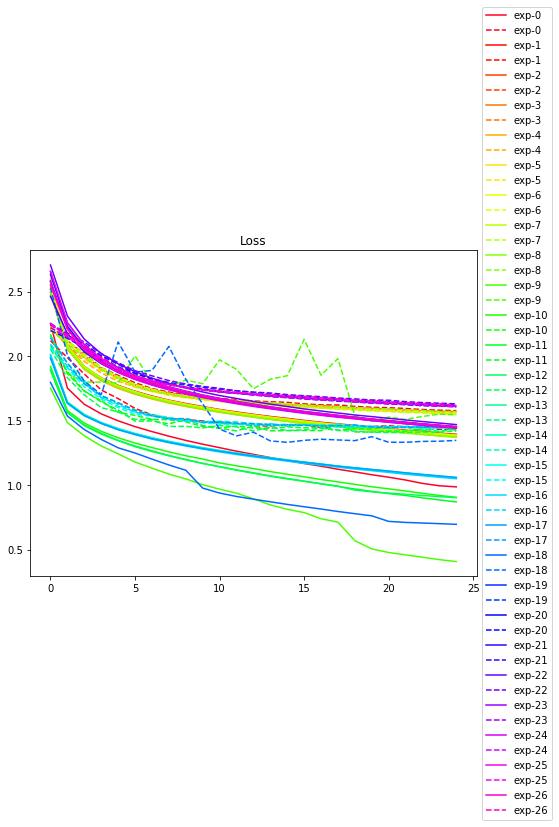

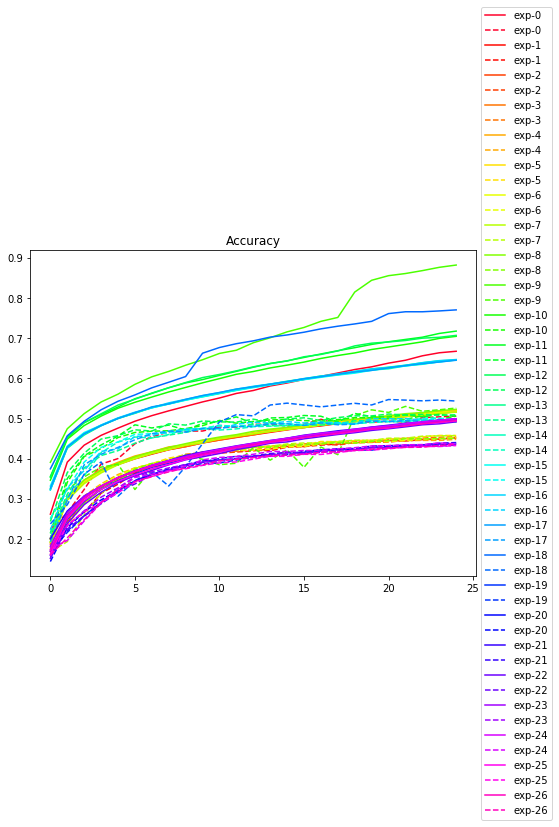

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()